In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"invigi","key":"857527af94eefc0ada9a9b1252a84b87"}'}

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd
!chmod 600 /root/.kaggle/kaggle.json

-rw-r--r-- 1 root root 62 Oct 16 03:29 kaggle.json
/content


In [ ]:
import kagglehub
path = kagglehub.dataset_download("faldoae/padangfood")
path = "/root/.cache/kagglehub/datasets/faldoae/padangfood/versions/1/dataset_padang_food/"

100%|██████████| 114M/114M [00:00<00:00, 227MB/s] 

Extracting files...


In [ ]:
!pip install tensorflow keras matplotlib scikeras

INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report

In [ ]:
seed = 2000
size = 224
input_shape = (size, size, 3)
num_classes = 9
batch = 64
epochs = 50

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    channel_shift_range=0.2,
    fill_mode='nearest',
    validation_split=0.2,
)

train_data = train_datagen.flow_from_directory(
    path,
    target_size=(size, size),
    batch_size=batch,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    path,
    target_size=(size, size),
    batch_size=batch,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

train_num = train_data.samples
validation_num = val_data.samples

print (train_num)
print (validation_num)

Found 799 images belonging to 9 classes.
Found 194 images belonging to 9 classes.
799
194


In [ ]:
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       7

In [ ]:
filepath = os.path.join(os.getcwd(), "best_model.keras")

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [ ]:
history=model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=train_num//batch,
    validation_steps=validation_num//batch,
    validation_data=val_data,
    callbacks=[checkpoint],
)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 2.3099 - acc: 0.1537
Epoch 1: val_acc improved from -inf to 0.23958, saving model to /content/best_model.keras
12/12 [==============================] - 23s 2s/step - loss: 2.3099 - acc: 0.1537 - val_loss: 2.0862 - val_acc: 0.2396
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 2.0576 - acc: 0.2476
Epoch 2: val_acc did not improve from 0.23958
12/12 [==============================] - 20s 2s/step - loss: 2.0576 - acc: 0.2476 - val_loss: 2.0652 - val_acc: 0.2292
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.9728 - acc: 0.2653
Epoch 3: val_acc improved from 0.23958 to 0.27604, saving model to /content/best_model.keras
12/12 [==============================] - 20s 2s/step - loss: 1.9728 - acc: 0.2653 - val_loss: 1.9308 - val_acc: 0.2760
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 1.8655 - acc: 0.2980
Epoch 4: val_acc improved from 0.27604 to 0.41146, saving 

4/4 [==============================] - 4s 749ms/step


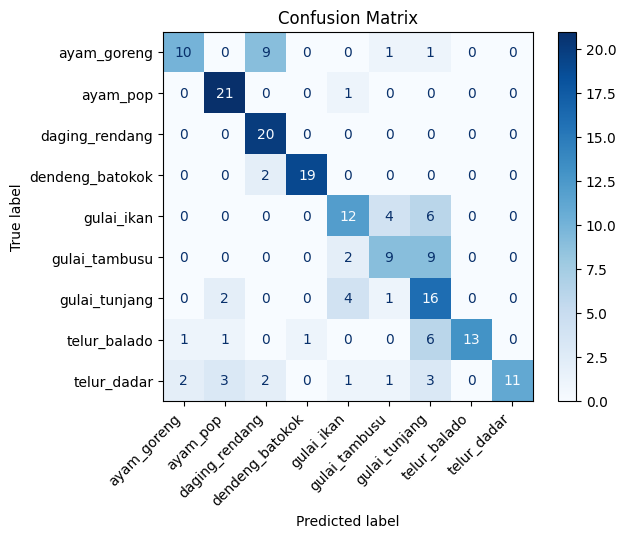

In [ ]:
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred_classes)
labels = list(val_data.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.78      0.95      0.86        22
           2       0.61      1.00      0.75        20
           3       0.95      0.90      0.93        21
           4       0.60      0.55      0.57        22
           5       0.56      0.45      0.50        20
           6       0.39      0.70      0.50        23
           7       1.00      0.59      0.74        22
           8       1.00      0.48      0.65        23

    accuracy                           0.68       194
   macro avg       0.74      0.68      0.68       194
weighted avg       0.74      0.68      0.68       194



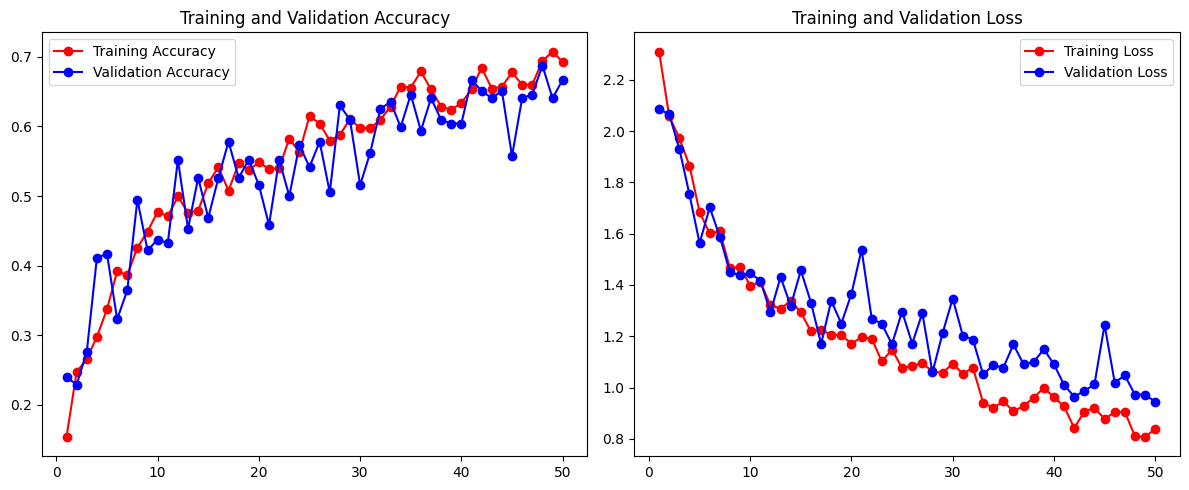

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'red', label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'red', label='Training Loss', marker='o')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_accuracy = model.evaluate(train_data)
val_loss, val_accuracy = model.evaluate(val_data)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

4/4 [==============================] - 3s 722ms/step - loss: 0.9236 - acc: 0.6959
Training Accuracy: 0.7234
Validation Accuracy: 0.6959


1/1 [==============================] - 0s 38ms/step


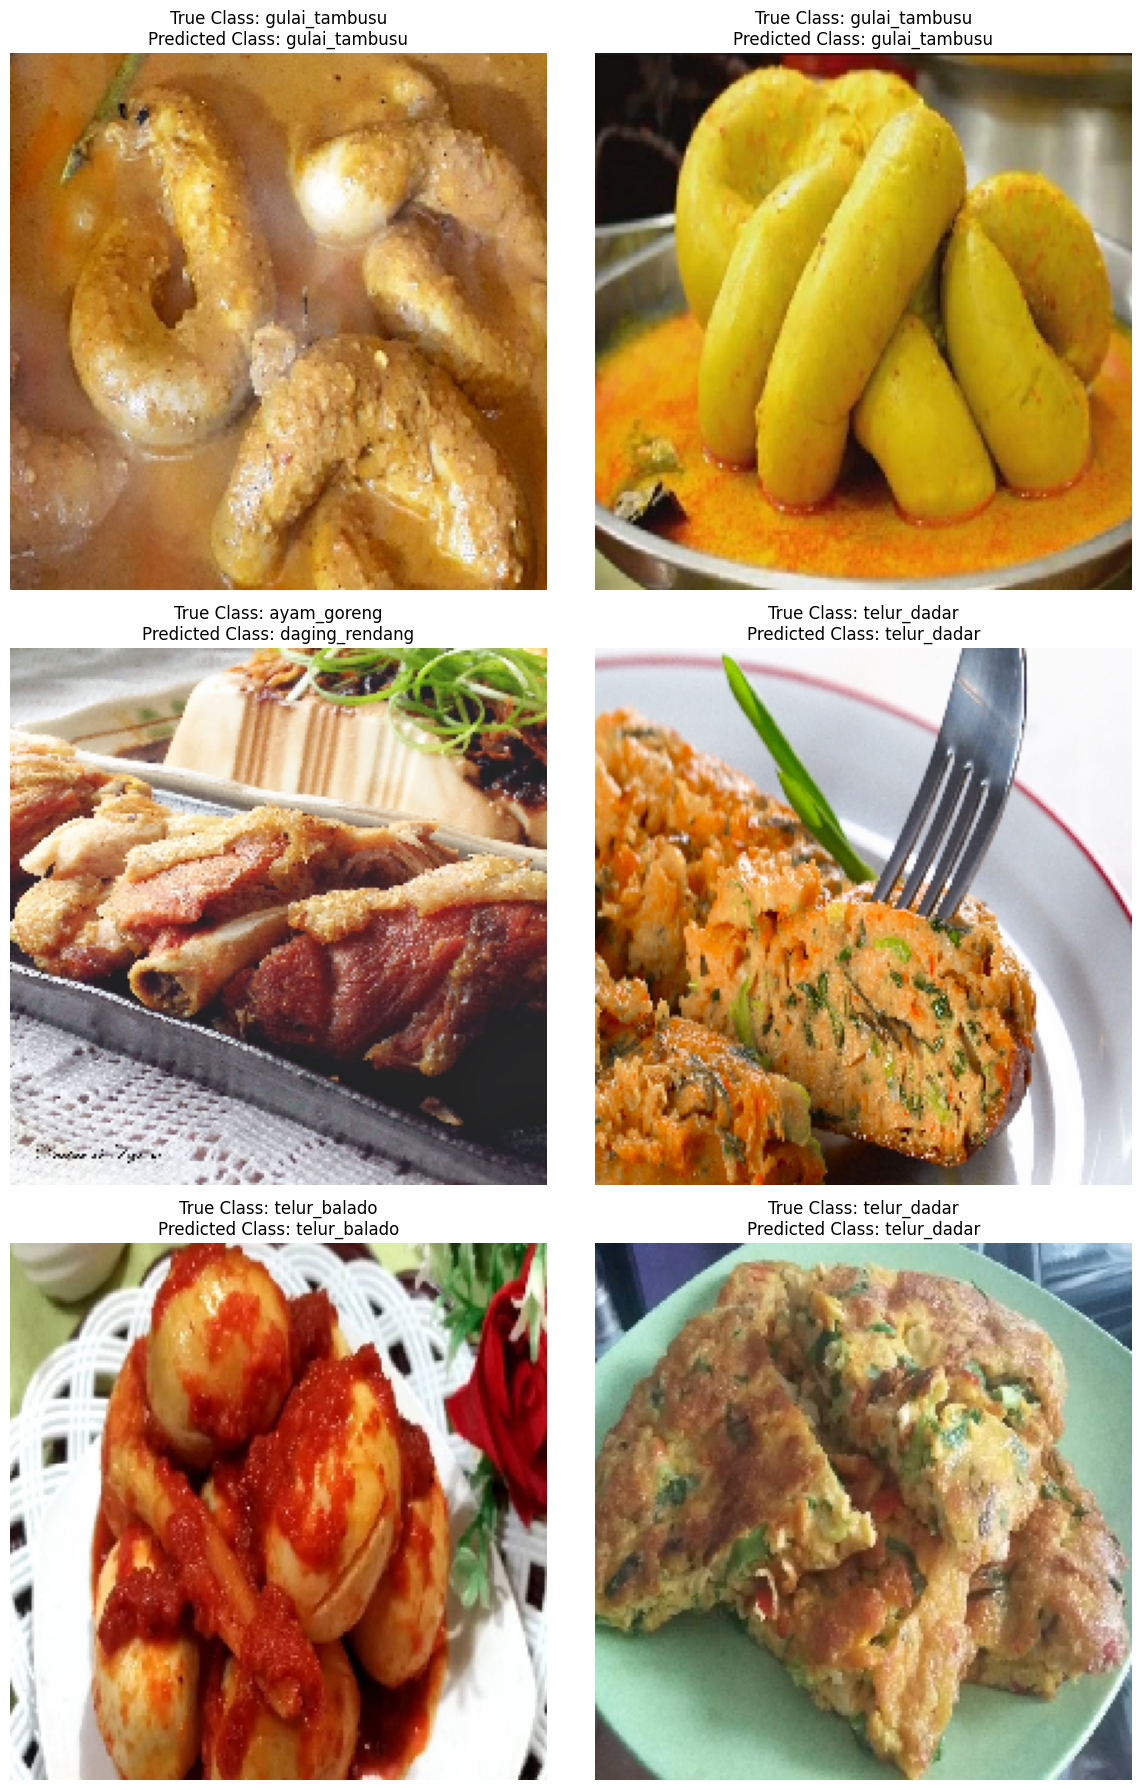

In [ ]:
sample_indexes = random.sample(range(train_num), 6)
plt.figure(figsize=(12, 18))

for i, idx in enumerate(sample_indexes):
    img_path = train_data.filepaths[idx]
    true_class_idx = train_data.labels[idx]
    true_class_label = list(train_data.class_indices.keys())[true_class_idx]

    img = image.load_img(img_path, target_size=(size, size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_class_label = list(train_data.class_indices.keys())[predicted_class]

    plt.subplot(3, 2, i + 1)
    plt.imshow(img)
    plt.title(f"True Class: {true_class_label}\nPredicted Class: {predicted_class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()